# Предсказание коэффициента восстановления золота из золотосодержащей руды

### Содержание работы

**[Введение](#0)**

**[1. Подготовка данных](#1)** 
   
**[2. Анализ данных](#2)**
     
**[3. Построение модели](#3)** 

**[Заключение](#4)**

## Описание проекта <a id="0"></a>

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## 1. Подготовка данных <a id="1"></a>

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.core.common import SettingWithCopyWarning
from tqdm import tqdm

Откроем данные обучающей, тестовой и полной выборки и сохраним в соответствующих переменных:

In [2]:
gold_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_full = pd.read_csv('/datasets/gold_recovery_full.csv')

Изучим общую информацию о каждой выборке:

In [3]:
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [4]:
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [5]:
gold_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

Во всех выборках имеются пропущенные значения, которые необходимо будет обработать.

Число переменных в тестовой выборке `gold_test` меньше переменных в обучающей и полной выборках. В частности, в тестовой выборке отсутствуют переменные, характеризующие сырьё, прошедшее определённые этапы обработки, в том числе отсутствуют значения целевых переменных `rougher.output.recovery` и `final.output.recovery`.

Полный список признаков, недоступных в тестовой выборке:

In [6]:
set(gold_train.columns.tolist()).difference(gold_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Восстановим значения целевых признаков для тестовой выборки из полного датасета:

In [7]:
gold_test = gold_test.merge(gold_full[['date', 'rougher.output.recovery', 'final.output.recovery']], how='left', on='date')

In [8]:
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 0 to 5855
Data columns (total 55 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

Проверим, корректно ли рассчитаны показатели восстановления руды. Для этого создадим датафрейм, в котором нет пропущенных значений переменных, по которым рассчитываются данные показатели:

In [9]:
recovery_calc = gold_train[['rougher.output.recovery', 'rougher.output.concentrate_au',\
                            'rougher.input.feed_au', 'rougher.output.tail_au']].dropna()

In [10]:
recovery_calc.head()

,rougher.output.recovery,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au
0,87.107763,19.793808,6.486150,1.170244
1,86.843261,20.050975,6.478583,1.184827
2,86.842308,19.737170,6.362222,1.162562
3,87.226430,19.320810,6.118189,1.079755
4,86.688794,19.216101,5.663707,1.012642


In [11]:
C = recovery_calc['rougher.output.concentrate_au']
F = recovery_calc['rougher.input.feed_au']
T = recovery_calc['rougher.output.tail_au']

recovery_calc['recovery_calculated'] = C*(F-T)/(F*(C-T))*100

Рассчитаем MAE между рассчетным и заданным показателем восстановления руды `rougher.output.recovery`:

In [12]:
mean_absolute_error(recovery_calc['rougher.output.recovery'], recovery_calc['recovery_calculated'])

9.444891926100695e-15

Ошибка практически равна 0. Незначительное отклонение может быть объяснено округлением заданного показателя. **Вывод:** эффективность обогащения в исходных данных рассчитана верно.

Для обучающей выборки отберем только те признаки, которые доступны в тестовом датасете. Также заполним пропущенные значения обучающей выборки с помощью метода 'bfill' (т.к. близкие по времени наблюдения обладают схожими значениями признаков). Наблюдения с пропущенными значениями целевых признаков удалим.

In [13]:
columns_test = gold_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1).columns.tolist()
columns_model = gold_test.columns.tolist()

gold_train = gold_train[columns_model].sort_values(by='date')
gold_train[columns_test] = gold_train[columns_test].fillna(method='ffill')
gold_train = gold_train.dropna()
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 55 columns):
date                                          14149 non-null object
primary_cleaner.input.sulfate                 14149 non-null float64
primary_cleaner.input.depressant              14149 non-null float64
primary_cleaner.input.feed_size               14149 non-null float64
primary_cleaner.input.xanthate                14149 non-null float64
primary_cleaner.state.floatbank8_a_air        14149 non-null float64
primary_cleaner.state.floatbank8_a_level      14149 non-null float64
primary_cleaner.state.floatbank8_b_air        14149 non-null float64
primary_cleaner.state.floatbank8_b_level      14149 non-null float64
primary_cleaner.state.floatbank8_c_air        14149 non-null float64
primary_cleaner.state.floatbank8_c_level      14149 non-null float64
primary_cleaner.state.floatbank8_d_air        14149 non-null float64
primary_cleaner.state.floatbank8_d_level      14149 non-null flo

Аналогично обработаем пропущенные значения в тестовой и полной выборках.

In [14]:
gold_test = gold_test[columns_model].sort_values(by='date')
gold_test[columns_test] = gold_test[columns_test].fillna(method='ffill')
gold_test = gold_test.dropna()#.drop('date', axis=1)
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5855
Data columns (total 55 columns):
date                                          5290 non-null object
primary_cleaner.input.sulfate                 5290 non-null float64
primary_cleaner.input.depressant              5290 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5290 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.in

In [15]:
columns_full_features = gold_full.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1).columns
gold_full[columns_full_features] = gold_full[columns_full_features].fillna(method='ffill')
gold_full = gold_full.dropna()
gold_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19439 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  19439 non-null object
final.output.concentrate_ag                           19439 non-null float64
final.output.concentrate_pb                           19439 non-null float64
final.output.concentrate_sol                          19439 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19439 non-null float64
final.output.tail_pb                                  19439 non-null float64
final.output.tail_sol                                 19439 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19439 non-null float64
primary_cleaner.input.depressant             

### Вывод по шагу 1

На шаге 1 были открыты исходные данные и сохранены в соответствующие переменные, были обработаны пропущенные значения. В обучающей выборке были оставлены только те признаки, которые имеются в тестовой.

## 2. Анализ данных <a id="2"></a>

Изучим, как меняется концентрация металлов на различных этапах очистки:

Концентрация металлов на разных стадиях обработки


,Au,Ag,Pb
Исходное сырье,8.000,9.000,4.000
Флотация,19.772,11.995,7.606
Первая очистка,32.119,8.442,9.800
Вторая очистка,44.077,5.168,9.979


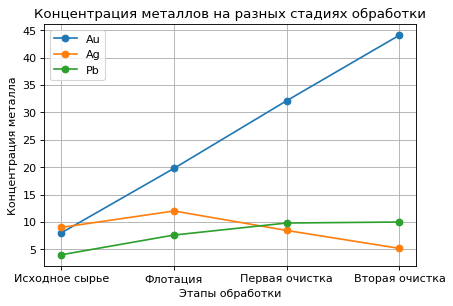

In [16]:
au_1 = gold_full['rougher.input.feed_au'].mean()
au_2 = gold_full['rougher.output.concentrate_au'].mean()
au_3 = gold_full['primary_cleaner.output.concentrate_au'].mean()
au_4 = gold_full['final.output.concentrate_au'].mean()

ag_1 = gold_full['rougher.input.feed_ag'].mean()
ag_2 = gold_full['rougher.output.concentrate_ag'].mean()
ag_3 = gold_full['primary_cleaner.output.concentrate_ag'].mean()
ag_4 = gold_full['final.output.concentrate_ag'].mean()

pb_1 = gold_full['rougher.input.feed_pb'].mean()
pb_2 = gold_full['rougher.output.concentrate_pb'].mean()
pb_3 = gold_full['primary_cleaner.output.concentrate_pb'].mean()
pb_4 = gold_full['final.output.concentrate_pb'].mean()

concentration_index = pd.Series(['Исходное сырье', 'Флотация', 'Первая очистка', 'Вторая очистка'])
concentration_data = {'Au': [round(au_1,0), round(au_2,3), round(au_3,3), round(au_4,3)],\
                 'Ag': [round(ag_1,0), round(ag_2,3), round(ag_3,3), round(ag_4,3)],\
                 'Pb': [round(pb_1,0), round(pb_2,3), round(pb_3,3), round(pb_4,3)]}

concentration_df = pd.DataFrame(data = concentration_data).set_index(concentration_index)
print('Концентрация металлов на разных стадиях обработки')
display(concentration_df)

plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')

for metal in concentration_df.columns:
    plt.plot(concentration_df.index.tolist(), concentration_df.loc[:, metal], 'o-')
    
plt.legend(concentration_df.columns)
plt.grid()
plt.title('Концентрация металлов на разных стадиях обработки')
plt.xlabel('Этапы обработки')
plt.ylabel('Концентрация металла')
plt.show()

Концентрация золота возрастает линейно на всех этапах. Концентрация свинца возрастает нелинейно и более медленно. Концентрация серебра возрастает после флотации, а на последующих этапах падает.

Сравним распределение размера гранул исходного сырья на обучающей и тестовой выборках.

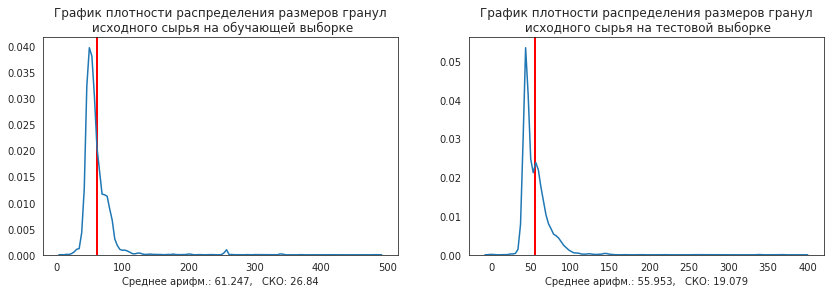

In [17]:
fig = plt.figure(figsize=(14, 4))
gs = fig.add_gridspec(1, 2)

rougher_size_train = gold_train['rougher.input.feed_size']
rougher_size_test = gold_test['rougher.input.feed_size']
primary_size_train = gold_train['primary_cleaner.input.feed_size']
primary_size_test = gold_test['primary_cleaner.input.feed_size']

with sns.axes_style("white"):
    ax1 = fig.add_subplot(gs[0, 0])
    plt.axvline(x=rougher_size_train.mean(), color="red", linewidth=2)
    sns.kdeplot(rougher_size_train, legend=False)
    ax1.set_title('График плотности распределения размеров гранул\n исходного сырья на обучающей выборке')
    plt.xlabel('Среднее арифм.: ' + str(round(np.mean(rougher_size_train), 3)) +\
               ',   СКО: ' + str(round(np.std(rougher_size_train), 3)))
    
with sns.axes_style("white"):
    ax2 = fig.add_subplot(gs[0, 1])
    plt.axvline(x=rougher_size_test.mean(), color="red", linewidth=2)
    sns.kdeplot(rougher_size_test, legend=False)
    ax2.set_title('График плотности распределения размеров гранул\n исходного сырья на тестовой выборке')
    plt.xlabel('Среднее арифм.: ' + str(round(np.mean(rougher_size_test), 3)) +\
               ',   СКО: ' + str(round(np.std(rougher_size_test), 3)))

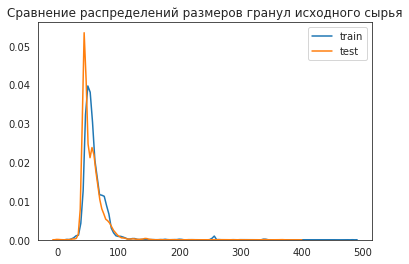

In [18]:
fig = plt.figure(figsize=(6, 4))

rougher_size_train = gold_train['rougher.input.feed_size']
rougher_size_test = gold_test['rougher.input.feed_size']

with sns.axes_style("white"):
    sns.kdeplot(rougher_size_train)
    sns.kdeplot(rougher_size_test)
    plt.legend(['train', 'test'])
    plt.title('Сравнение распределений размеров гранул исходного сырья')

Визуально распределения схожи, но не идентичны. Ср. арифметические и стандартные отклонения отличаются на ~ 4 ед. Очищение выборок от выбросов позволит сгладить различия двух выборок.

Аналогично, сравним распределения размеров гранул для чернового концентрата:

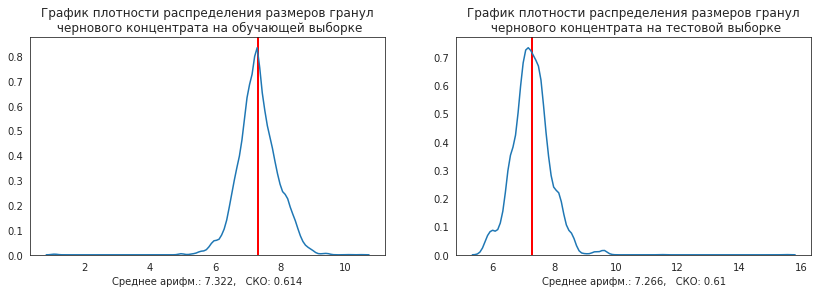

In [19]:
fig = plt.figure(figsize=(14, 4))
gs = fig.add_gridspec(1, 2)

primary_size_train = gold_train['primary_cleaner.input.feed_size']
primary_size_test = gold_test['primary_cleaner.input.feed_size']


with sns.axes_style("white"):
    ax1 = fig.add_subplot(gs[0, 0])
    plt.axvline(x=primary_size_train.mean(), color="red", linewidth=2)
    sns.kdeplot(primary_size_train, legend=False)
    ax1.set_title('График плотности распределения размеров гранул\n чернового концентрата на обучающей выборке')
    plt.xlabel('Среднее арифм.: ' + str(round(np.mean(primary_size_train), 3)) +\
               ',   СКО: ' + str(round(np.std(primary_size_train), 3)))
    
with sns.axes_style("white"):
    ax2 = fig.add_subplot(gs[0, 1])
    plt.axvline(x=primary_size_test.mean(), color="red", linewidth=2)
    sns.kdeplot(primary_size_test, legend=False)
    ax2.set_title('График плотности распределения размеров гранул\n чернового концентрата на тестовой выборке')
    plt.xlabel('Среднее арифм.: ' + str(round(np.mean(primary_size_test), 3)) +\
               ',   СКО: ' + str(round(np.std(primary_size_test), 3)))

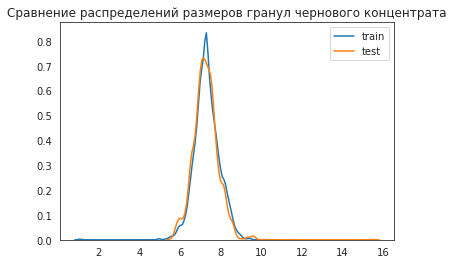

In [20]:
fig = plt.figure(figsize=(6, 4))

primary_size_train = gold_train['primary_cleaner.input.feed_size']
primary_size_test = gold_test['primary_cleaner.input.feed_size']

with sns.axes_style("white"):
    sns.kdeplot(primary_size_train)
    sns.kdeplot(primary_size_test)
    plt.legend(['train', 'test'])
    plt.title('Сравнение распределений размеров гранул чернового концентрата')

Визуально распределения ещё более схожи. Средние значения и стандартные отклонения практически равны.

Исследуем суммарную концентрацию металлов на разных стадиях обработки:

In [21]:
np.warnings.filterwarnings('ignore', category=SettingWithCopyWarning)

columns_concentrations = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'final.output.concentrate_au',\
                          'rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'final.output.concentrate_ag',\
                          'rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'final.output.concentrate_pb',\
                          'rougher.input.feed_sol', 'rougher.output.concentrate_sol', 'final.output.concentrate_sol']

gfc = gold_full[columns_concentrations]

gfc['rougher.concentrate'] = (
    gfc['rougher.input.feed_au'] + gfc['rougher.input.feed_ag'] +\
    gfc['rougher.input.feed_pb'] + gfc['rougher.input.feed_sol'])

gfc['flotation.concentrate'] = (
    gfc['rougher.output.concentrate_au'] + gfc['rougher.output.concentrate_ag'] +\
    gfc['rougher.output.concentrate_pb'] + gfc['rougher.output.concentrate_sol'])

gfc['final.concentrate'] = (
    gfc['final.output.concentrate_au'] + gfc['final.output.concentrate_ag'] +\
    gfc['final.output.concentrate_pb'] + gfc['final.output.concentrate_sol'])

gfc.head()

,rougher.input.feed_au,rougher.output.concentrate_au,final.output.concentrate_au,rougher.input.feed_ag,rougher.output.concentrate_ag,final.output.concentrate_ag,rougher.input.feed_pb,rougher.output.concentrate_pb,final.output.concentrate_pb,rougher.input.feed_sol,rougher.output.concentrate_sol,final.output.concentrate_sol,rougher.concentrate,flotation.concentrate,final.concentrate
0,6.486150,19.793808,42.192020,6.100378,11.500771,6.055403,2.284912,7.101074,9.889648,36.808594,28.029297,5.507324,51.680034,66.424950,63.644396
1,6.478583,20.050975,42.701629,6.161113,11.615865,6.029369,2.266033,7.278807,9.968944,35.753385,28.067063,5.257781,50.659114,67.012710,63.957723
2,6.362222,19.737170,42.657501,6.116455,11.695753,6.055926,2.159622,7.216833,10.213995,35.971630,27.454037,5.383759,50.609929,66.103793,64.311180
3,6.118189,19.320810,42.689819,6.043309,11.915047,6.047977,2.037807,7.175616,9.977019,36.862241,27.341277,4.858634,51.061546,65.752751,63.573449
4,5.663707,19.216101,42.774141,6.060915,12.411054,6.148599,1.786875,7.240205,10.142511,34.347666,27.041023,4.939416,47.859163,65.908382,64.004667


In [22]:
def outliers(series, normal=False):
    
    #Функция возвращает диапазон нормальных значений выборки на основе межквартильного расстояния, если normal=False,
    #и на основе стандартного отклонения, еcли normal=True
    
    Q1 = series.describe()['25%']
    Q3 = series.describe()['75%']
    
    IQR = Q3-Q1
    
    mean = series.describe()['50%']
    std = series.describe()['std']
    
    if normal == False:
    
        if Q1-1.5*IQR < series.describe()['min']:
            lower_boundary = series.describe()['min']
        
        else:
            lower_boundary = Q1-1.5*IQR
    
        if Q3+1.5*IQR > series.describe()['max']:
            upper_boundary = series.describe()['max']
        
        else:
            upper_boundary = Q3+1.5*IQR
            
    else:
        
        if mean-3*std < series.describe()['min']:
            lower_boundary = series.describe()['min']
        
        else:
            lower_boundary = mean-3*std
    
        if mean+3*std > series.describe()['max']:
            upper_boundary = series.describe()['max']
        
        else:
            upper_boundary = mean+3*std
    
    return (lower_boundary, upper_boundary)

In [23]:
def cut_outliers(DataFrame, column, normal = False, lower = None, upper = None):
    
    # Функция принимает в качестве аргументов название data-фрейма и столбца и возвращает очищенный от 
    # выбросов срез
    
    # Опционально можно самостоятельно указать в качестве аргумента нижнюю (lower) и / или верхнюю (upper) 
    # границу среза
       
    if normal == False:
    
        lower_est = outliers(DataFrame[column], normal=False)[0]
        upper_est = outliers(DataFrame[column], normal=False)[1]
        
    else:
        lower_est = outliers(DataFrame[column], normal=True)[0]
        upper_est = outliers(DataFrame[column], normal=True)[1]
    
    if lower != None:
        lower_boundary = lower
    
    else:
        lower_boundary = lower_est
        
    if upper != None:
        upper_boundary = upper
    
    else:
        upper_boundary = upper_est
    
    cut = DataFrame[(DataFrame[column] >= lower_boundary) & (DataFrame[column] <= upper_boundary)]
    
    return cut

In [24]:
def explore(df, column, name, normal=False, cut=False, describe=False, lower=None
            , upper=None, bins=None, hist_only=False, density=False, qq_plot=False):
    
    # Функция принимает название data-фрейма, название столбца, имя переменной и строит гистограмму и ящик с усами
    # при cut=True диапазон графиков сжимается до (Q1-2*IQR, Q3+2*IQR)
    # при describe=True вызывается метод .describe() и функция outliers()
    # при density=True вместо гистограммы строится график плотности
    # при normal=True выбросы определяются на основе правила 3-сигм; в противном случае — на основе IQR
    # при qq_plot=True строится QQ-график
    # опционально можно скорректировать диапазон значений графиков и количество корзин гистограммы
    
    if normal==False:
        
            lower_outlier = outliers(df[column], normal=False)[0]
            upper_outlier = outliers(df[column], normal=False)[1]
        
    else:
            
            lower_outlier = outliers(df[column], normal=True)[0]
            upper_outlier = outliers(df[column], normal=True)[1]
    
    if cut==False:
        
        if density==False:
            
            if bins==None:
                df[column].hist()
            else:
                df[column].hist(bins=bins)
            plt.title('Гистограмма '+ name)
            plt.show()
        
        else:
            
            sns.kdeplot(df[column], legend=False)
            plt.title('График плотности '+ name)
            plt.show()
        
        if hist_only==False:
            df.boxplot(column=column)
            plt.title('Диаграмма размаха '+ name)
            plt.show()

    else:
        min = df[column].describe()['min']
        max = df[column].describe()['max']
        
                
        iqr = df[column].describe()['75%']-df[column].describe()['25%']
        
        if lower==None:
            if round((lower_outlier-min),0)==0:
                lower_boundary=min-0.1*iqr
            else:
                lower_boundary=lower_outlier-0.5*iqr
        else:
            lower_boundary=lower
            
        if upper==None:
            if round((upper_outlier-max),0)==0:
                upper_boundary=max+0.1*iqr
            else:
                upper_boundary=upper_outlier+0.5*iqr
        else:
            upper_boundary=upper
        
        if density==False:
            
            if bins==None:
                if (upper_boundary-lower_boundary)>8:
                    df[column].hist(range=(lower_boundary, upper_boundary), bins=int(upper_boundary-lower_boundary))
                else:
                    df[column].hist(range=(lower_boundary, upper_boundary), bins=8)
            else:
                df[column].hist(range=(lower_boundary, upper_boundary), bins=bins)
        
            plt.title('Гистограмма '+ name)
            plt.show()
        
        else:   

            sns.kdeplot(df[column], legend=False)
            plt.xlim(lower_boundary, upper_boundary)
            plt.title('График плотности '+ name)
            plt.show()
        
        if hist_only==False:
            df.boxplot(column=column)
            plt.title('Диаграмма размаха '+ name)
            plt.ylim(lower_boundary, upper_boundary)
            plt.show()
    
    if qq_plot==True:
        stats.probplot(df[column], dist="norm", plot=plt)
        plt.show()
    
    if describe==True:
        print(df[column].describe())
        print('')
        if lower_outlier == df[column].describe()['min'] and upper_outlier == df[column].describe()['max']:
            print('Выбросы не обнаружены')
        else:
            print('Диапазон нормальных значений:', (lower_outlier, upper_outlier))
            print('')
            print('Очищенная от выбросов выборка:')
            print('')
            if normal==False:
                print(cut_outliers(df, column, normal=False)[column].describe())
            else:
                print(cut_outliers(df, column, normal=True)[column].describe())

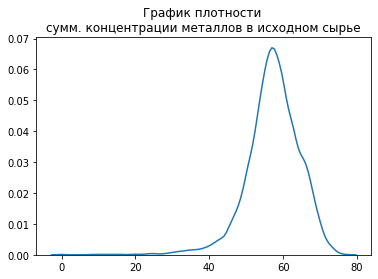

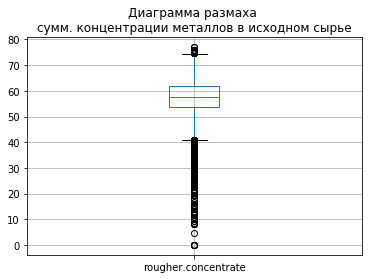

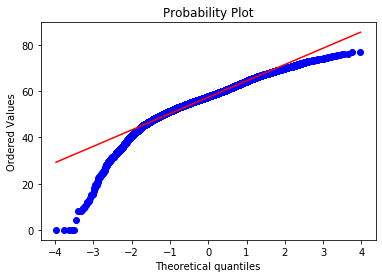

count    19439.000000
mean        57.310846
std          7.243999
min          0.040000
25%         53.556969
50%         57.591781
75%         61.952764
max         76.978947
Name: rougher.concentrate, dtype: float64

Диапазон нормальных значений: (40.96327578373702, 74.54645765866626)

Очищенная от выбросов выборка:

count    18956.000000
mean        57.882233
std          6.125633
min         40.983839
25%         53.900027
50%         57.749888
75%         62.069418
max         74.458303
Name: rougher.concentrate, dtype: float64


In [25]:
explore(gfc, 'rougher.concentrate', name='\nсумм. концентрации металлов в исходном сырье', normal=False
        , qq_plot = True, density=True, describe=True)

Распределение практически симметричное и, судя по QQ-графику близко к нормальному. Имеются выбросы слева. Очищение выбросов на основе межквартильного расстояния приводит к незначительному сокращению выборки и потому видится приемлемым.

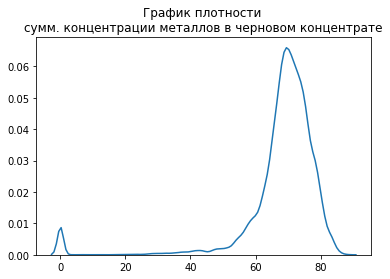

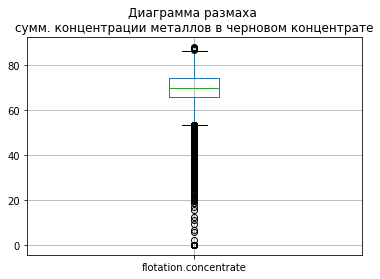

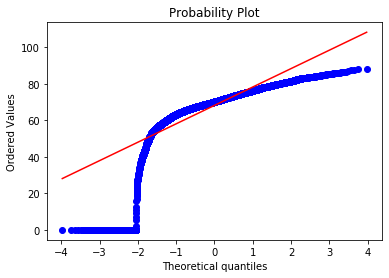

count    19439.000000
mean        68.161527
std         12.505637
min          0.000000
25%         66.008721
50%         70.177427
75%         74.356904
max         88.140119
Name: flotation.concentrate, dtype: float64

Диапазон нормальных значений: (53.486446324431896, 86.87917890321866)

Очищенная от выбросов выборка:

count    18421.000000
mean        70.465343
std          5.963460
min         53.503790
25%         66.853752
50%         70.610025
75%         74.616685
max         86.538614
Name: flotation.concentrate, dtype: float64


In [26]:
explore(gfc, 'flotation.concentrate', name='\nсумм. концентрации металлов в черновом концентрате', normal=False
        , qq_plot = True, density=True, describe=True)

Наблюдается длинный левый хвост с большим числом нулевых значений (вероятно, ошибка оборудования). Также присутствуют выбросы сверху. Очищение от выбросов на основе межквартильного расстояния существенно сокращает размер выборки, видится целесообразным расширить расчётные границы.

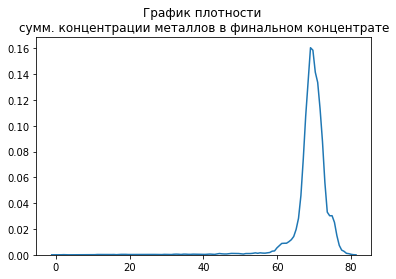

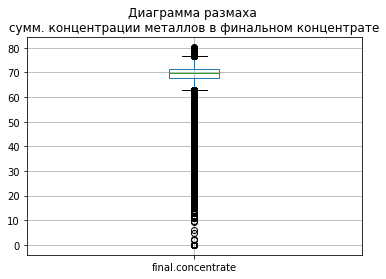

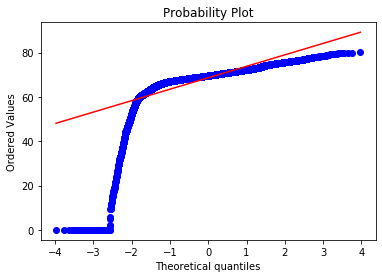

count    19439.000000
mean        68.645831
std          7.434908
min          0.000000
25%         67.931190
50%         69.598444
75%         71.368472
max         80.210644
Name: final.concentrate, dtype: float64

Диапазон нормальных значений: (62.77526610667777, 76.52439549899489)

Очищенная от выбросов выборка:

count    18102.000000
mean        69.880016
std          2.497707
min         62.782222
25%         68.280775
50%         69.753880
75%         71.427278
max         76.519097
Name: final.concentrate, dtype: float64


In [27]:
explore(gfc, 'final.concentrate', name='\nсумм. концентрации металлов в финальном концентрате', normal=False
        , qq_plot = True, density=True, describe=True)

Наблюдается еще более длинный левый хвост. Присутствуют выбросы и снизу, и сверху. Очищение от выбросов на основе межквартильного расстояния существенно сокращает размер выборки, видится целесообразным расширить расчётные границы.

Аналогично изучим распределения размеров гранул исходного сырья и чернового концентрата:

In [28]:
gfs = gold_full[['rougher.input.feed_size', 'primary_cleaner.input.feed_size']]
gfs.head()

,rougher.input.feed_size,primary_cleaner.input.feed_size
0,55.486599,7.25
1,57.278666,7.25
2,57.510649,7.25
3,57.792734,7.25
4,56.047189,7.25


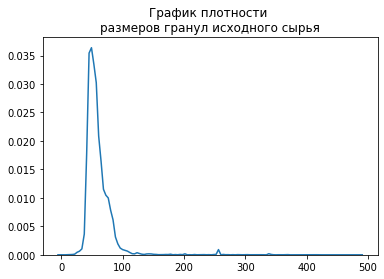

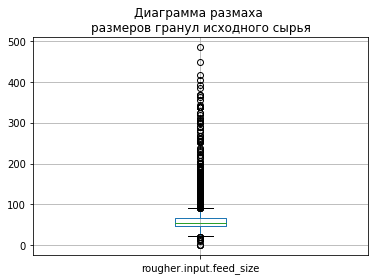

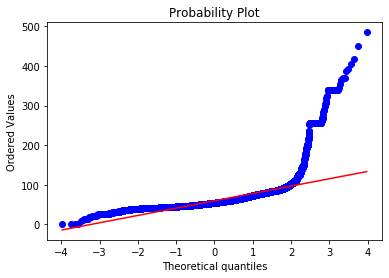

count    19439.000000
mean        59.806364
std         25.079200
min          0.046369
25%         47.485218
50%         54.657105
75%         65.265548
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Диапазон нормальных значений: (20.81472400964817, 91.9360424454844)

Очищенная от выбросов выборка:

count    18746.000000
mean        56.604817
std         12.188200
min         21.345670
25%         47.232987
50%         54.138941
75%         63.687552
max         91.933473
Name: rougher.input.feed_size, dtype: float64


In [29]:
explore(gfs, 'rougher.input.feed_size', name='\nразмеров гранул исходного сырья', normal=False
        , qq_plot = True, density=True, describe=True)

Распределение правостороннее, наблюдается большое число выбросов сверху, также присутствуют выбросы снизу. Очищение от выбросов на основе межквартильного расстояния существенно сокращает размер выборки, видится целесообразным расширить расчётные границы.

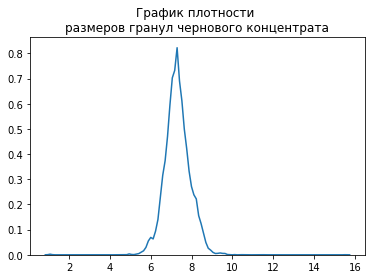

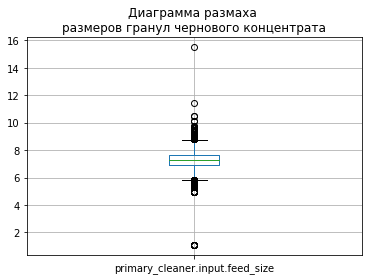

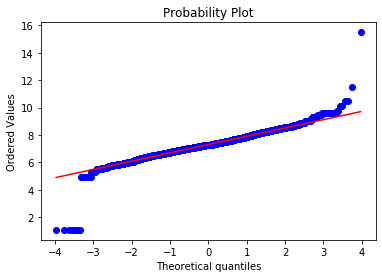

count    19439.000000
mean         7.307078
std          0.613509
min          1.080000
25%          6.940000
50%          7.280000
75%          7.670000
max         15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

Диапазон нормальных значений: (5.8450000286102295, 8.765000104904175)

Очищенная от выбросов выборка:

count    19100.000000
mean         7.304842
std          0.553901
min          5.850000
25%          6.945000
50%          7.280000
75%          7.650000
max          8.760000
Name: primary_cleaner.input.feed_size, dtype: float64


In [30]:
explore(gfs, 'primary_cleaner.input.feed_size', name='\nразмеров гранул чернового концентрата', normal=False
        , qq_plot = True, density=True, describe=True)

Распределение практически симметричное, имеются выбросы сверху и снизу.

Сохраним индексы полной выборки с очищенными от выбросами наблюдений. Границы нормальных значений основаны на расчётных (по межквартильному расстоянию) и впоследствии расширены на основе визуального анализа графика плотности распределения и диаграммых размаха, для сохранения большего числа наблюдений.

In [31]:
rougher_indices = cut_outliers(gfc, 'rougher.concentrate', normal=False, lower=20, upper=76).index.tolist()
flotation_indices = cut_outliers(gfc, 'flotation.concentrate', normal=False, lower=20, upper=87).index.tolist()
final_indices = cut_outliers(gfc, 'final.concentrate', normal=False, lower=20, upper=81).index.tolist()

rougher_size_indices = cut_outliers(gfs, 'rougher.input.feed_size', normal=False, lower=20, upper=200).index.tolist()
primary_size_indices = cut_outliers(gfs, 'primary_cleaner.input.feed_size', normal=False, lower=4,upper=10).index.tolist()

rougher_set = set(rougher_indices)
intersection_indices = list(rougher_set.intersection(flotation_indices, final_indices,\
                                                     rougher_size_indices, primary_size_indices))

print(len(intersection_indices))

18704


Всего на пересечении индексов очищенных выборок находится 18699 наблюдения — исходная выборка сократилась незначительно.

Отберём из исходной (полной) выборки наблюдения с найденными индексами:

In [32]:
gold_full_cleared = pd.DataFrame(gold_full, index=intersection_indices, columns=gold_full.columns)[columns_model]
gold_full_cleared.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,...,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763,70.541216
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,...,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261,69.266198
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,...,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308,68.116445
3,2016-01-15 03:00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,...,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,87.226430,68.347543
4,2016-01-15 04:00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,...,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,86.688794,66.927016


Отберем найденные наблюдения и в тренировочной выборке, найдя её пересечение по дате с полной выборкой.

In [33]:
gold_train_cleared = gold_train.merge(gold_full_cleared, on='date', how='inner',  suffixes=(None, '_y'))[columns_model]
gold_train_cleared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13579 entries, 0 to 13578
Data columns (total 55 columns):
date                                          13579 non-null object
primary_cleaner.input.sulfate                 13579 non-null float64
primary_cleaner.input.depressant              13579 non-null float64
primary_cleaner.input.feed_size               13579 non-null float64
primary_cleaner.input.xanthate                13579 non-null float64
primary_cleaner.state.floatbank8_a_air        13579 non-null float64
primary_cleaner.state.floatbank8_a_level      13579 non-null float64
primary_cleaner.state.floatbank8_b_air        13579 non-null float64
primary_cleaner.state.floatbank8_b_level      13579 non-null float64
primary_cleaner.state.floatbank8_c_air        13579 non-null float64
primary_cleaner.state.floatbank8_c_level      13579 non-null float64
primary_cleaner.state.floatbank8_d_air        13579 non-null float64
primary_cleaner.state.floatbank8_d_level      13579 non-null flo

Аналогично очистим тестовую выборку:

In [34]:
gold_test_cleared = gold_test.merge(gold_full_cleared, on='date', how='inner',  suffixes=(None, '_y'))[columns_model]
gold_test_cleared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5125 entries, 0 to 5124
Data columns (total 55 columns):
date                                          5125 non-null object
primary_cleaner.input.sulfate                 5125 non-null float64
primary_cleaner.input.depressant              5125 non-null float64
primary_cleaner.input.feed_size               5125 non-null float64
primary_cleaner.input.xanthate                5125 non-null float64
primary_cleaner.state.floatbank8_a_air        5125 non-null float64
primary_cleaner.state.floatbank8_a_level      5125 non-null float64
primary_cleaner.state.floatbank8_b_air        5125 non-null float64
primary_cleaner.state.floatbank8_b_level      5125 non-null float64
primary_cleaner.state.floatbank8_c_air        5125 non-null float64
primary_cleaner.state.floatbank8_c_level      5125 non-null float64
primary_cleaner.state.floatbank8_d_air        5125 non-null float64
primary_cleaner.state.floatbank8_d_level      5125 non-null float64
rougher.in

Убедимся, что распредедения размеров гранул сырья в обучающей и тестовой выборках после очищения выбросов стали более близкими:

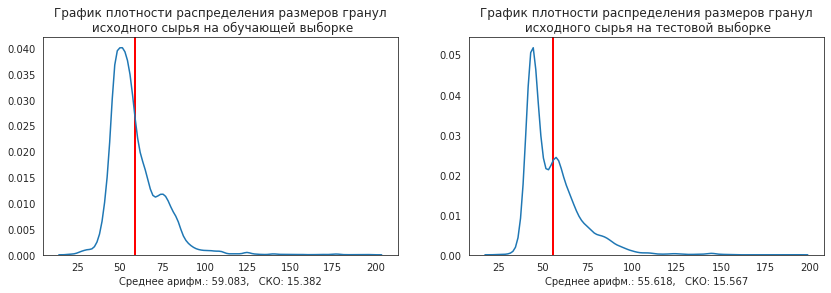

In [35]:
fig = plt.figure(figsize=(14, 4))
gs = fig.add_gridspec(1, 2)

rougher_size_train = gold_train_cleared['rougher.input.feed_size']
rougher_size_test = gold_test_cleared['rougher.input.feed_size']

with sns.axes_style("white"):
    ax1 = fig.add_subplot(gs[0, 0])
    plt.axvline(x=rougher_size_train.mean(), color="red", linewidth=2)
    sns.kdeplot(rougher_size_train, legend=False)
    ax1.set_title('График плотности распределения размеров гранул\n исходного сырья на обучающей выборке')
    plt.xlabel('Среднее арифм.: ' + str(round(np.mean(rougher_size_train), 3)) +\
               ',   СКО: ' + str(round(np.std(rougher_size_train), 3)))
    
with sns.axes_style("white"):
    ax2 = fig.add_subplot(gs[0, 1])
    plt.axvline(x=rougher_size_test.mean(), color="red", linewidth=2)
    sns.kdeplot(rougher_size_test, legend=False)
    ax2.set_title('График плотности распределения размеров гранул\n исходного сырья на тестовой выборке')
    plt.xlabel('Среднее арифм.: ' + str(round(np.mean(rougher_size_test), 3)) +\
               ',   СКО: ' + str(round(np.std(rougher_size_test), 3)))

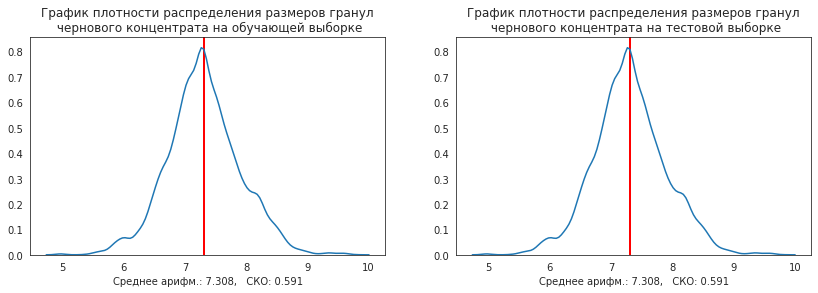

In [36]:
fig = plt.figure(figsize=(14, 4))
gs = fig.add_gridspec(1, 2)

primary_size_train = gold_full_cleared['primary_cleaner.input.feed_size']
primary_size_test = gold_full_cleared['primary_cleaner.input.feed_size']

with sns.axes_style("white"):
    ax1 = fig.add_subplot(gs[0, 0])
    plt.axvline(x=primary_size_train.mean(), color="red", linewidth=2)
    sns.kdeplot(primary_size_train, legend=False)
    ax1.set_title('График плотности распределения размеров гранул\n чернового концентрата на обучающей выборке')
    plt.xlabel('Среднее арифм.: ' + str(round(np.mean(primary_size_train), 3)) +\
               ',   СКО: ' + str(round(np.std(primary_size_train), 3)))
    
with sns.axes_style("white"):
    ax2 = fig.add_subplot(gs[0, 1])
    plt.axvline(x=primary_size_test.mean(), color="red", linewidth=2)
    sns.kdeplot(primary_size_test, legend=False)
    ax2.set_title('График плотности распределения размеров гранул\n чернового концентрата на тестовой выборке')
    plt.xlabel('Среднее арифм.: ' + str(round(np.mean(primary_size_test), 3)) +\
               ',   СКО: ' + str(round(np.std(primary_size_test), 3)))

Распределения практически идентичны.

В исходных выборках наблюдения отсортированы по дате. Для повышения предсказательной способности моделей, в чатсности, при проведении кросс-валидации, перемешаем наблюдения в выборках. Также сохраним значения целевых и незавимисых признаков в соответствующих переменных.

In [37]:
gold_full_cleared = gold_full_cleared.sample(frac=1, random_state=12345).reset_index(drop=True)
gold_train_cleared = gold_train_cleared.sample(frac=1, random_state=12345).reset_index(drop=True)
gold_test_cleared = gold_test_cleared.sample(frac=1, random_state=12345).reset_index(drop=True)

target_rougher_full = gold_full_cleared['rougher.output.recovery']
target_final_full = gold_full_cleared['final.output.recovery']
target_rougher_train = gold_train_cleared['rougher.output.recovery']
target_final_train = gold_train_cleared['final.output.recovery']
target_rougher_test = gold_test_cleared['rougher.output.recovery']
target_final_test = gold_test_cleared['final.output.recovery']

features_full = gold_full_cleared.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
features_train = gold_train_cleared.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
features_test = gold_test_cleared.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)

print(target_rougher_full.shape)
print(target_rougher_train.shape)
print(target_rougher_test.shape)
print(features_full.shape)
print(features_train.shape)
print(features_test.shape)

(18704,)
(13579,)
(5125,)
(18704, 52)
(13579, 52)
(5125, 52)


Стандартизируем признаки во всех выборках на основе среднего и дисперсии обучающей выборки.

In [38]:
scaler = StandardScaler()
scaler.fit(features_train)

features_full = pd.DataFrame(scaler.transform(features_full), index=features_full.index, columns=features_full.columns)
features_train = pd.DataFrame(scaler.transform(features_train), index=features_train.index, columns=features_train.columns)
features_test = pd.DataFrame(scaler.transform(features_test), index=features_test.index, columns=features_test.columns)

Для определения статистически значимых переменных построим предварительную модель регрессии для первого целевого признака:

In [39]:
Y = target_rougher_train
X = features_train
X = sm.add_constant(X)

pre_model_rougher = sm.OLS(Y, X)
results = pre_model_rougher.fit()
display(results.summary())

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     rougher.output.recovery   R-squared:                       0.552
Model:                                 OLS   Adj. R-squared:                  0.550
Method:                      Least Squares   F-statistic:                     319.9
Date:                     Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                             10:47:50   Log-Likelihood:                -41743.
No. Observations:                    13579   AIC:                         8.359e+04
Df Residuals:                        13526   BIC:                         8.399e+04
Df Model:                               52                                         
Covariance Type:                 nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         84.6227      0.045   1880.378      0.000      84.534      84.711
primary_cleaner.input.sulfate                  1.8421      0.091     20.271      0.000       1.664       2.020
primary_cleaner.input.depressant              -0.1413      0.072     -1.970      0.049      -0.282      -0.001
primary_cleaner.input.feed_size                0.5226      0.055      9.465      0.000       0.414       0.631
primary_cleaner.input.xanthate                -0.2243      0.061     -3.654      0.000      -0.345      -0.104
primary_cleaner.state.floatbank8_a_air        -0.1531      0.172     -0.890      0.374      -0.490       0.184
primary_cleaner.state.floatbank8_a_level       0.3874      0.216      1.794      0.073      -0.036       0.811
primary_cleaner.state.floatbank8_b_air         1.2421      0.182      6.825      0.000       0.885       1.599
primary_cleaner.state.floatbank8_b_level      -0.5915      0.180     -3.281      0.001      -0.945      -0.238
primary_cleaner.state.floatbank8_c_air        -0.3887      0.169     -2.300      0.021      -0.720      -0.058
primary_cleaner.state.floatbank8_c_level       0.5052      0.179      2.830      0.005       0.155       0.855
primary_cleaner.state.floatbank8_d_air        -0.9643      0.066    -14.695      0.000      -1.093      -0.836
primary_cleaner.state.floatbank8_d_level      -0.0982      0.069     -1.427      0.154      -0.233       0.037
rougher.input.feed_ag                          1.0731      0.103     10.390      0.000       0.871       1.276
rougher.input.feed_pb                          0.2900      0.089      3.264      0.001       0.116       0.464
rougher.input.feed_rate                       -1.7899      0.097    -18.452      0.000      -1.980      -1.600
rougher.input.feed_size                        0.2214      0.063      3.499      0.000       0.097       0.345
rougher.input.feed_sol                         1.6890      0.066     25.500      0.000       1.559       1.819
rougher.input.feed_au                          0.4189      0.134      3.116      0.002       0.155       0.682
rougher.input.floatbank10_sulfate             -2.2458      0.177    -12.694      0.000      -2.593      -1.899
rougher.input.floatbank10_xanthate             2.4377      0.161     15.156      0.000       2.122       2.753
rougher.input.floatbank11_sulfate              0.9116      0.196      4.661      0.000       0.528       1.295
rougher.input.floatbank11_xanthate            -1.1212      0.199     -5.637      0.000      -1.511      -0.731
rougher.state.floatbank10_a_air               -1.0543      0.085    -12.453      0.000      -1.220      -0.888
rougher.state.floatbank10_a_lev

Отсортируем переменные по значению p.value:

In [40]:
pvals = results.pvalues.round(3).sort_values()
pvals

const                                         0.000
secondary_cleaner.state.floatbank6_a_air      0.000
rougher.state.floatbank10_c_air               0.000
rougher.state.floatbank10_d_air               0.000
rougher.state.floatbank10_e_air               0.000
rougher.state.floatbank10_f_air               0.000
secondary_cleaner.state.floatbank2_a_air      0.000
secondary_cleaner.state.floatbank2_a_level    0.000
secondary_cleaner.state.floatbank2_b_air      0.000
secondary_cleaner.state.floatbank2_b_level    0.000
secondary_cleaner.state.floatbank3_a_air      0.000
secondary_cleaner.state.floatbank3_a_level    0.000
secondary_cleaner.state.floatbank3_b_air      0.000
secondary_cleaner.state.floatbank3_b_level    0.000
secondary_cleaner.state.floatbank4_a_air      0.000
secondary_cleaner.state.floatbank4_b_air      0.000
secondary_cleaner.state.floatbank4_b_level    0.000
secondary_cleaner.state.floatbank5_a_air      0.000
secondary_cleaner.state.floatbank5_b_air      0.000
secondary_cl

Найдем такое пороговое значение p.value, при котором информационный критерий Акаике (AIC) минимален. Это позволит исключить из последующих моделей избыточные переменные. Названия оставшихся переменных сохраним в списке `rougher_features`. 

In [41]:
rougher_features = []

best_aic = 1_000_000
best_i = 0
for i in tqdm(range(10, 30)):
    
    selected_features = pvals[pvals<(i/100)].index.tolist()
    selected_features.remove('const')
    
    Y = target_rougher_train
    X = features_train[selected_features]
    X = sm.add_constant(X)

    model_rougher = sm.OLS(Y, X)
    results = model_rougher.fit()
    
    if results.aic <= best_aic:
        best_i = i
        best_aic = results.aic
        rougher_features = selected_features
       
print(best_i, best_aic)

100%|██████████| 20/20 [00:10<00:00,  1.87it/s]

29 83586.12559209722


Аналогично построим предварительную модель для второго целевого признака:

In [42]:
Y2 = target_final_train
X = features_train
X = sm.add_constant(X)

pre_model_final = sm.OLS(Y2, X)
results4 = pre_model_final.fit()
display(results4.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     final.output.recovery   R-squared:                       0.359
Model:                               OLS   Adj. R-squared:                  0.356
Method:                    Least Squares   F-statistic:                     145.4
Date:                   Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                           10:48:02   Log-Likelihood:                -46322.
No. Observations:                  13579   AIC:                         9.275e+04
Df Residuals:                      13526   BIC:                         9.315e+04
Df Model:                             52                                         
Covariance Type:               nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         66.8586      0.063   1060.380      0.000      66.735      66.982
primary_cleaner.input.sulfate                  1.4266      0.127     11.205      0.000       1.177       1.676
primary_cleaner.input.depressant              -0.2852      0.100     -2.839      0.005      -0.482      -0.088
primary_cleaner.input.feed_size                0.4383      0.077      5.665      0.000       0.287       0.590
primary_cleaner.input.xanthate                 0.1670      0.086      1.942      0.052      -0.002       0.336
primary_cleaner.state.floatbank8_a_air         0.0872      0.241      0.362      0.717      -0.385       0.560
primary_cleaner.state.floatbank8_a_level      -0.5462      0.303     -1.805      0.071      -1.139       0.047
primary_cleaner.state.floatbank8_b_air         0.4627      0.255      1.815      0.070      -0.037       0.962
primary_cleaner.state.floatbank8_b_level       2.8445      0.253     11.262      0.000       2.349       3.340
primary_cleaner.state.floatbank8_c_air        -0.6951      0.237     -2.936      0.003      -1.159      -0.231
primary_cleaner.state.floatbank8_c_level      -1.4789      0.250     -5.913      0.000      -1.969      -0.989
primary_cleaner.state.floatbank8_d_air        -0.1118      0.092     -1.216      0.224      -0.292       0.068
primary_cleaner.state.floatbank8_d_level      -0.8598      0.096     -8.917      0.000      -1.049      -0.671
rougher.input.feed_ag                         -0.3268      0.145     -2.259      0.024      -0.610      -0.043
rougher.input.feed_pb                         -1.1533      0.124     -9.264      0.000      -1.397      -0.909
rougher.input.feed_rate                       -0.2168      0.136     -1.595      0.111      -0.483       0.050
rougher.input.feed_size                        0.3815      0.089      4.304      0.000       0.208       0.555
rougher.input.feed_sol                         1.0635      0.093     11.460      0.000       0.882       1.245
rougher.input.feed_au                          3.9244      0.188     20.834      0.000       3.555       4.294
rougher.input.floatbank10_sulfate             -1.9701      0.248     -7.948      0.000      -2.456      -1.484
rougher.input.floatbank10_xanthate             2.2698      0.225     10.073      0.000       1.828       2.712
rougher.input.floatbank11_sulfate              0.4577      0.274      1.670      0.095      -0.079       0.995
rougher.input.floatbank11_xanthate            -0.2524      0.279     -0.906      0.365      -0.799       0.294
rougher.state.floatbank10_a_air               -0.8299      0.119     -6.997      0.000      -1.062      -0.597
rougher.state.floatbank10_a_level              0.4436

In [43]:
pvals4 = results4.pvalues.round(3).sort_values()
pvals4

const                                         0.000
rougher.input.floatbank10_sulfate             0.000
rougher.input.floatbank10_xanthate            0.000
rougher.state.floatbank10_a_air               0.000
rougher.state.floatbank10_e_air               0.000
rougher.state.floatbank10_e_level             0.000
rougher.state.floatbank10_f_air               0.000
rougher.input.feed_au                         0.000
secondary_cleaner.state.floatbank2_a_air      0.000
secondary_cleaner.state.floatbank2_b_level    0.000
secondary_cleaner.state.floatbank3_a_air      0.000
secondary_cleaner.state.floatbank4_a_air      0.000
secondary_cleaner.state.floatbank5_a_air      0.000
secondary_cleaner.state.floatbank5_b_air      0.000
secondary_cleaner.state.floatbank5_b_level    0.000
secondary_cleaner.state.floatbank2_b_air      0.000
rougher.input.feed_sol                        0.000
rougher.state.floatbank10_b_level             0.000
primary_cleaner.state.floatbank8_b_level      0.000
primary_clea

Также найдем пороговое значение p.v., минимизируюзее критерий AIC. Выбранные переменные сохраним в списке `final_features`.

In [44]:
final_features = []
best_aic_2 = 1_000_000
best_i_2 = 0
for i in tqdm(range(10, 30)):
    
    selected_features = pvals[pvals4<(i/100)].index.tolist()
    selected_features.remove('const')
    
    Y = target_final_train
    X = features_train[selected_features]
    X = sm.add_constant(X)

    model_final = sm.OLS(Y, X)
    results = model_final.fit()
    
    if results.aic <= best_aic_2:
        best_i_2 = i
        best_aic_2 = results.aic
        final_features = selected_features
       
print(best_i_2, best_aic_2)

100%|██████████| 20/20 [00:09<00:00,  2.14it/s]

23 92739.94203416797


### Вывод по шагу 2

На шаге 2 была изучена концентрация металлов в сырье на различных стадиях обработки, были изучены распределения гранул сырья. Данные всех выборок были очищены от наблюдений с экстремальными значениями суммарной концентрации металлов и размеров гранул сырья. Также были построены предварительные модели регрессии, на основе которых были выделены статистически значимые признаки для использования в последующих моделях.

## 3. Модель <a id="3"></a>

Определим функцию для расчёта метрики sMAPE.

In [45]:
def sMAPE(target, predictions):
    error = 0
    target_reset = target.reset_index(drop=True)
    for i in range(target.shape[0]):
        error += abs(target_reset[i]-predictions[i])/((abs(target_reset[i]+abs(predictions[i])))/2)
    return error/target.shape[0]*100

In [46]:
def final_sMAPE(rougher, final):
    return 0.25 * rougher + 0.75 * final

In [47]:
def cross_validate(features, target, model):

    sample_size = int(len(features)/3)

    smapes = []

    for i in range(0, (len(features)-1), sample_size):
        valid_indexes = list(range(i, i + sample_size))
        train_indexes = list(range(0, i)) + list(range(valid_indexes[-1], (len(features)-1)))
    
        features_train = features.loc[train_indexes]
        target_train = target.loc[train_indexes]
        features_valid = features.loc[valid_indexes]
        target_valid = target.loc[valid_indexes]
    
        model0 = model.fit(features_train, target_train)
        predictions_valid = model0.predict(features_valid)
    
        smape = sMAPE(target_valid, predictions_valid)
        smapes.append(smape)
    
    mean_smape = pd.Series(smapes).mean()

    return mean_smape

Построим две модели регрессии для каждого целевого признака. Проверим качество моделей с помощью кросс-валидации (5 блоков) на основе метрики sMAPE:

In [48]:
state = np.random.RandomState(12345)

model = LinearRegression()

smape_rougher = cross_validate(features_train[rougher_features], target_rougher_train, model)
smape_final = cross_validate(features_train[final_features], target_final_train, model)
final_smape = final_sMAPE(smape_rougher, smape_final)

print('Среднее значение sMAPE(rougher):', smape_rougher.round(3))
print('Среднее значение sMAPE(final):', smape_final.round(3))
print('Итоговое sMAPE:', final_smape.round(3))

Среднее значение sMAPE(rougher): 4.559
Среднее значение sMAPE(final): 7.975
Итоговое sMAPE: 7.121


Убедимся, что удаление избыточных переменных, идентифицированных на шаге 2, улучшило метрики качества. Для этого построим модели без удаления избыточных признаков:

In [49]:
smape_rougher = cross_validate(features_train, target_rougher_train, model)
smape_final = cross_validate(features_train, target_final_train, model)
final_smape = final_sMAPE(smape_rougher, smape_final)

print('Среднее значение sMAPE(rougher):', smape_rougher.round(3))
print('Среднее значение sMAPE(final):', smape_final.round(3))
print('Итоговое sMAPE:', final_smape.round(3))

Среднее значение sMAPE(rougher): 4.56
Среднее значение sMAPE(final): 7.979
Итоговое sMAPE: 7.124


Метрики качества действительно немного лучше у моделей с удалёнными избыточными признаками.

Перейдем к построению моделей случайного леса. Подберем максимальную глубину, минимизирующую целевую метрику sMAPE для первого целевого признака. Метрика рассчитывается с помощью кросс-валидации (5 блоков).

In [50]:
smape_best_rougher = 100
best_model_rougher = None
best_depth_rougher = 0

for depth in tqdm(range(20, 30, 1)):
    
    model = RandomForestRegressor(n_estimators=20, max_depth=depth, random_state=12345)
    smape_rougher = cross_validate(features_train[rougher_features], target_rougher_train, model)
    
    if smape_rougher < smape_best_rougher:
        smape_best_rougher = smape_rougher
        best_depth_rougher = depth
        
print('Наилучшая глубина:', best_depth_rougher)
print('Наилучшее среднее значение sMAPE(rougher):', smape_best_rougher.round(3))

100%|██████████| 10/10 [04:59<00:00, 29.95s/it]

Наилучшая глубина: 26
Наилучшее среднее значение sMAPE(rougher): 2.694


Аналогично подберем максимальную глубину для второго целевого признака:

In [51]:
smape_best_final = 100
#best_model_final = None
best_depth_final = 0

for depth in tqdm(range(20, 30, 1)):
    
    model = RandomForestRegressor(n_estimators=20, max_depth=depth, random_state=12345)
    smape_final = cross_validate(features_train[final_features], target_final_train, model)
    
    if smape_final < smape_best_final:
        smape_best_final = smape_final
        best_depth_final = depth
        
print('Наилучшая глубина:', best_depth_final)
print('Наилучшее среднее значение sMAPE(rougher):', smape_best_final.round(3))

100%|██████████| 10/10 [04:32<00:00, 27.22s/it]

Наилучшая глубина: 27
Наилучшее среднее значение sMAPE(rougher): 5.93


Используя найденные значения максимальной глубины, построим модели с увеличенным числом деревьев. Убедимся, что значения sMAPE улучшились, рассчитаем итоговое значение sMAPE. Для оценки качества по-прежнему используется кросс-валидация с 5 блоками.

In [52]:
model1 = RandomForestRegressor(n_estimators=60, max_depth=26, random_state=12345)
model2 = RandomForestRegressor(n_estimators=60, max_depth=27, random_state=12345)

smape_rougher = cross_validate(features_train[rougher_features], target_rougher_train, model1)
smape_final = cross_validate(features_train[final_features], target_final_train, model2)
final_smape = final_sMAPE(smape_rougher, smape_final)

print('Среднее значение sMAPE(rougher):', smape_rougher.round(3))
print('Среднее значение sMAPE(final):', smape_final.round(3))
print('Итоговое sMAPE:', final_smape.round(3))

Среднее значение sMAPE(rougher): 2.606
Среднее значение sMAPE(final): 5.803
Итоговое sMAPE: 5.004


Проверим качество моделей на тестовой выборке.

In [53]:
model = RandomForestRegressor(n_estimators=60, max_depth=26, random_state=12345)
model_rougher_test = model.fit(features_train[rougher_features], target_rougher_train)
predictions_rougher_test = model_rougher_test.predict(features_test[rougher_features])
    
smape_rougher = sMAPE(target_rougher_test, predictions_rougher_test)

model = RandomForestRegressor(n_estimators=60, max_depth=27, random_state=12345)
model_final_test = model.fit(features_train[final_features], target_final_train)
predictions_final_test = model_final_test.predict(features_test[final_features])
    
smape_final = sMAPE(target_final_test, predictions_final_test)

final_smape_test = 0.25 * smape_rougher + 0.75 * smape_final

print('sMAPE(rougher):', smape_rougher.round(3))
print('sMAPE(final):', smape_final.round(3))
print('Итоговое sMAPE на тестовой выборке:', final_smape_test.round(3))

sMAPE(rougher): 4.234
sMAPE(final): 8.148
Итоговое sMAPE на тестовой выборке: 7.169


Метрики значительно ухудшились. Проверим модели на адекватность:

In [54]:
const_rougher = pd.Series(target_rougher_train.mean(), index=target_rougher_train.index) 
const_final = pd.Series(target_final_train.mean(), index=target_final_train.index) 

smape_rougher_const = sMAPE(target_rougher_test, const_rougher)
smape_final_const = sMAPE(target_final_test, const_final)
final_smape_const = final_sMAPE(smape_rougher_const, smape_final_const)
print('sMAPE(rougher) константной модели', smape_rougher_const.round(3))
print('sMAPE(final) константной модели', smape_final_const.round(3))
print('Итоговое sMAPE константных моделей', final_smape_const.round(3))

sMAPE(rougher) константной модели 5.192
sMAPE(final) константной модели 8.446
Итоговое sMAPE константных моделей 7.633


Обе модели прошли проверку на вменяемость.

## Общий вывод <a id="4"></a>

Таким образом, были изучены данные с параметрами добычи и очистки золотосодержащей руды.

Как и предполагалось, было установлено, что концентрация золота растёт на всех этапах обработки. Концентрация свинца также возрастает, но в меньших темпах. Концентрация серебра растет только после флотации, на последующих этапах падает.

В данных были обнаружены наблюдения с аномальными значениями концентрации руды (в том числе нулевыми значениями, вероятно появившимися вследствие ошибки оборудования), а также аномальными значениями размеров гранул сырья. Этим наблюдерния были исключены из последующего анализа во всех выборках.

С помощью регрессинного анализа и, в частности, информационного критерия Акаике AIC были определены значимые переменные для включения в последующие модели машинного обучения.

На основе данных обучающей выборки были построены модели регрессии и случайного леса, качество моделей было проверено кросс-валидацией. Наилучшее значение целевой метрики показали модели случайного леса с максимальной глубиной 26 и 27 для двух целевых признаков соответственно, число деревьев в обеих моделях — 60.

При тестировании моделей на тестовой выборке значения метрик ухудшились, тем не менее все модели прошли проверку на адекватность.